Duplicate of example_NGC1275_test_env.ipynb to test the new UF23 class

# Example to calculate photon-ALP oscillations from NGC 1275

This notebook demonstrates how to calculate the photon-ALP transition probability for NGC 1275, the central AGN of the Perseus cluster. The assumed B-field environments are the same as in Ajello et al. (2016), http://inspirehep.net/record/1432667, and include the cluster field and the magnetic field of the Milky Way. 

In [1]:
# to import gammaALPs, this cell should be only executed once after kernel restart
%cd ..

/afs/desy.de/user/f/flandgra/private/GMF/gammaALPs


In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

fatal: No names found, cannot describe anything.


In [3]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [4]:
m, g = 1.,1.
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [5]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
print (ngc1275.z)
print (ngc1275.ra, ngc1275.dec)
print (ngc1275.l, ngc1275.b)

0.017559
49.950416666666655 41.51166666666666
150.57567432060083 -13.261343544296325


### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments. 

Energies are supplied in GeV as ```numpy.ndarray```

In [6]:
EGeV = np.logspace(1.,3.5,250)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [7]:
pin = np.diag((1.,1.,0.)) * 0.5

In [8]:
m = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)

### Add modules:

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field.

In [9]:
m.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 10.,  # rms of B field
                  n0 = 3.9e-2,  # normalization of electron density
                  n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell = 500., # extension of the cluster
                  r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta = 0.5, # scaling of B-field with electron denstiy
                  kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q = -2.1, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )
m.add_propagation("EBL",1, model = 'dominguez') # EBL attenuation comes second, after beam has left cluster
m.add_propagation("GMF",2, model = 'UF23', model_sum = 'ASS', UF23_model='neCL') # finally, the beam enters the Milky Way Field

environs.py: 431 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi


List the module names:

In [10]:
print(m.modules.keys())

['MixICMGaussTurb', 'OptDepth', 'MixGMF']


We can also change the ALP parameters before running the modules:

In [11]:
m.alp.m = 30.
m.alp.g = 0.5

### Test the new F_q implementation

In [12]:
bfield = m.modules[0].Bfield_model

In [13]:
k = np.logspace(np.log10(bfield.kMin), np.log10(bfield.kH), bfield.dkSteps)

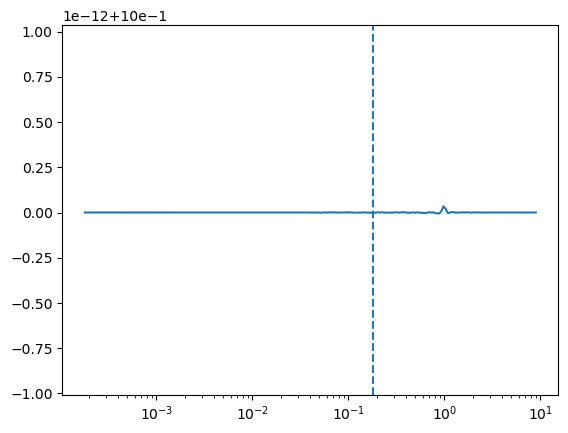

In [14]:
plt.semilogx(k, bfield.Fq(k) / bfield.Fq_old(k), ls='-')
plt.axvline(bfield.kL, ls='--')

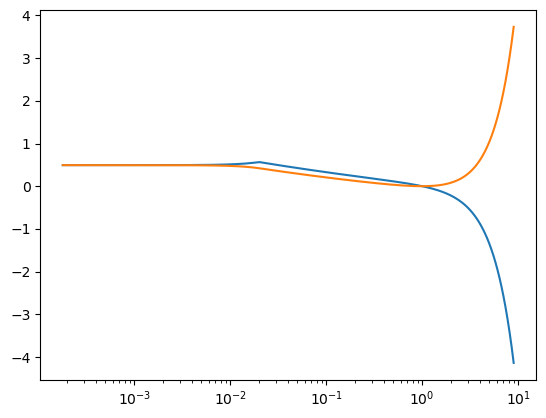

In [15]:
plt.semilogx(k, bfield.Fq(k))
plt.semilogx(k, bfield.Fq_longitudinal(k))

### Run all modules

Now we run the modules. If ```multiprocess``` key word is larger than two, this will be split onto multiple cores with python's ```multiprocess``` module.

The ```px,py,pa``` variables contain the mixing probability into the two photon polarization states (x,y) and into the axion state (a).

In [16]:
px,py,pa = m.run(multiprocess=2)

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


Test the matmul multiplication routine

In [17]:
for i, T in enumerate(m._Tenv):
    print(i, T.shape)

0 (10, 250, 3, 3)
1 (1, 250, 3, 3)
2 (1, 250, 3, 3)


In [20]:
from gammaALPs.base.transfer import calc_conv_prob

In [21]:
def calc_conv_prob_new(pin, pout, T):
    return np.squeeze(np.real(np.trace(
             (np.matmul(pout,
                        np.matmul(T,
                                  np.matmul(pin, np.transpose(T.conjugate(), axes=(0,1,2)))
                                  )
                        )
             ),
             axis1=1, axis2=2)))    

In [22]:
def calc_conv_prob_by_hand(pin, pout, T):
    # gives the same result as calc_conv_prob
    # loop over energies
    result = np.zeros(T.shape[0], dtype=np.float)
    
    for ie in range(T.shape[0]):
    
        Tdagger = np.transpose(np.conjugate(T[ie]))
        inner_most = np.dot(pin, Tdagger)
        inner = np.dot(T[ie], inner_most)
        outer = np.dot(pout, inner)
        result[ie] = np.real(np.trace(outer))
    
    return result

In [23]:
## wrong order
Tfinal_wrong = np.matmul(
                    np.matmul(m._Tenv[0][0], m._Tenv[1][0]),
                    m._Tenv[2][0]
)

## right order
Tfinal_right = np.matmul(
                    np.matmul(m._Tenv[2][0], m._Tenv[1][0]),
                    m._Tenv[0][0]
)

print (Tfinal_wrong.shape)

(250, 3, 3)


In [24]:
px_wrong = calc_conv_prob(m.pin, m.px, Tfinal_wrong)
px_also_wrong = calc_conv_prob_new(m.pin, m.px, Tfinal_wrong)

py_wrong = calc_conv_prob(m.pin, m.py, Tfinal_wrong)
py_also_wrong = calc_conv_prob_new(m.pin, m.py, Tfinal_wrong)

px_maybe_right = calc_conv_prob(m.pin, m.px, Tfinal_right)
# px_also_maybe_right = calc_conv_prob_by_hand(m.pin, m.px, Tfinal_right)

py_maybe_right = calc_conv_prob(m.pin, m.py, Tfinal_right)
# py_also_maybe_right = calc_conv_prob_by_hand(m.pin, m.py, Tfinal_right)

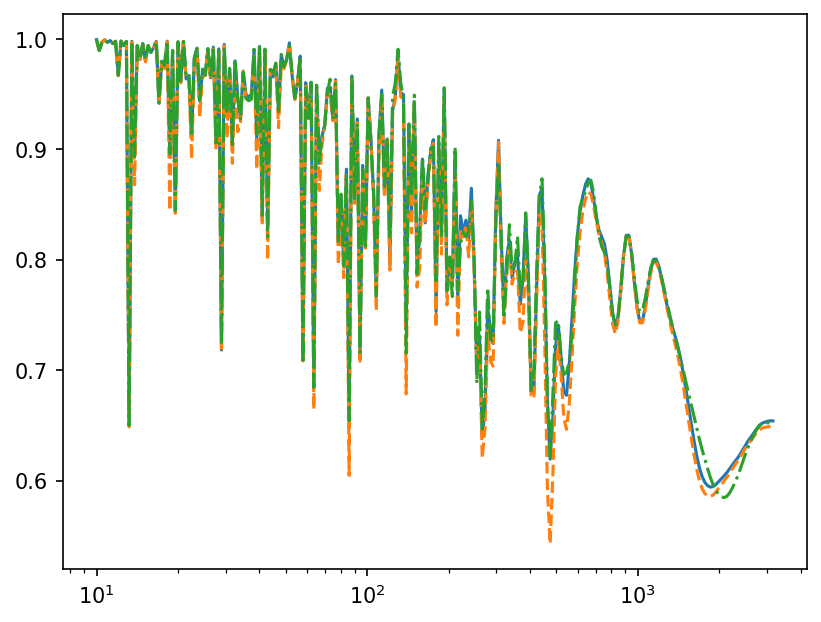

In [25]:
plt.figure(dpi=150)

plt.semilogx(m.EGeV, py_wrong + px_wrong)
plt.semilogx(m.EGeV, px_also_wrong + py_also_wrong, ls='--')


plt.semilogx(m.EGeV, py_maybe_right + px_maybe_right, ls='-.')
#plt.semilogx(m.EGeV, px_also_maybe_right, ls=':')


## Plot the output 

 legend.py:1363 --- WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 250)
0.5543117356105897
0.7270863113117513


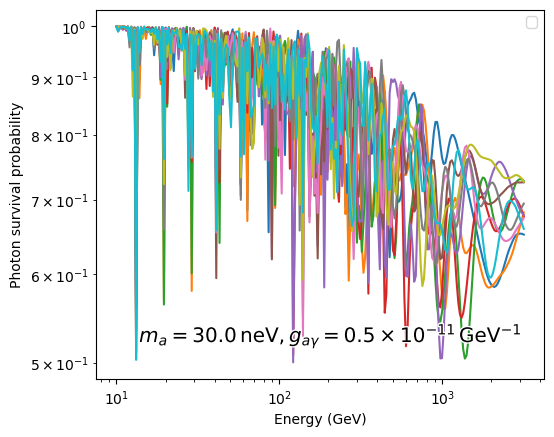

In [26]:
pgg = px + py # the total photon survival probability

print (pgg.shape)
print (np.min(np.median(pgg, axis = 0)))
print (np.min(np.max(pgg, axis = 0)))
effect = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

for p in pgg: # plot all realizations
    plt.semilogx(m.EGeV, p)

plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right',**effect)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)
plt.savefig("pgg.png", dpi = 150)

# Save results

Save the results in an astropy table. 

In [27]:
from astropy.table import Table

In [28]:
c = {}
c['pgg'] = np.vstack((EGeV, pgg))
t = Table(c)

In [29]:
t.write('ngc1275.fits', overwrite = True)

In [30]:
t1 = Table.read('ngc1275.fits')

In [31]:
t1

pgg
float64[250]
10.0 .. 3162.2776601683795
0.9995077307335614 .. 0.6512086131890906
0.9994652198392131 .. 0.681432278350778
0.9994613068839333 .. 0.7270863113117513
0.9995356199964069 .. 0.6760078969458532
0.9998957669412335 .. 0.678249713783724
0.9987188824242785 .. 0.725209794399444
0.9982677469662451 .. 0.6741051844170408
0.9990769130101876 .. 0.6940727308928863


### Plot the magnetic field of the cluster, stored in module 0

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_119471/3749018686.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$B$ field ($\mu$G)')


Text(0.5, 0, '$r$ (kpc)')

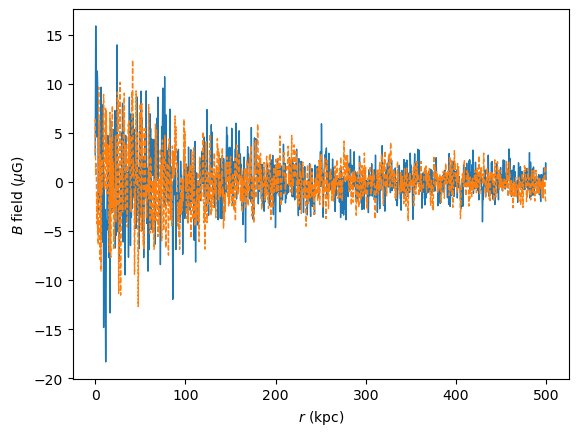

In [32]:
plt.plot(m.modules["ICMGaussTurb"].r,m.modules["ICMGaussTurb"].B * np.sin(m.modules["ICMGaussTurb"].psi),
         lw=1)
plt.plot(m.modules["ICMGaussTurb"].r,m.modules["ICMGaussTurb"].B * np.cos(m.modules["ICMGaussTurb"].psi),
         lw=1, ls = '--') 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')

And plot the electron density:

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_119471/694933722.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')


Text(0.5, 0, '$r$ (kpc)')

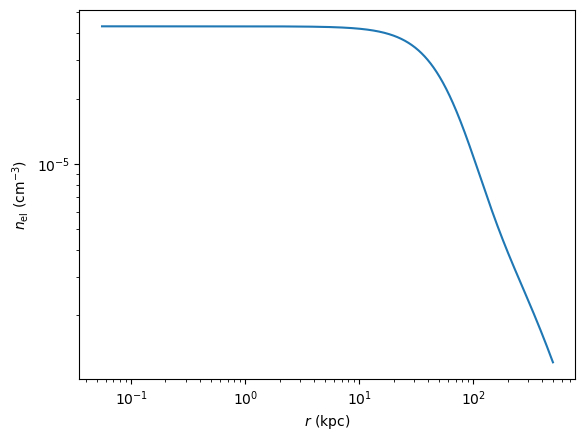

In [33]:
plt.loglog(m.modules["ICMGaussTurb"].r,m.modules[0].nel * 1e-3)
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

You can also manipulate the magnetic field and electron density at run time

#### Calculate the coherence length of the transversal component $B$ field

It is also possible to compute the spatial correlation $C(x_3) = \langle B_\perp(\vec{x}) B_\perp(\vec{x} + x_3 \vec{e}_3)\rangle$ of the transversal magnetic field along the line of sight $x_3$:

In [34]:
x3 = np.linspace(0.,50.,1000)  # distance in kpc from cluster center
c = m.modules["ICMGaussTurb"].Bfield_model.spatialCorr(x3) 

AttributeError: 'Bgaussian' object has no attribute 'spatialCorr'

In [35]:
plt.plot(x3,c / c[0])
plt.xlabel("$x_3$ (kpc)")
plt.ylabel("$C(x_3) / C(0)$")
plt.grid(True)

KeyError: 0

This is turn can be used to calculate the coherence length of the field, 
$$ \Lambda_C = \frac{1}{C(0)} \int\limits_0^\infty C(x_3)dx_3. $$


In [36]:
from scipy.integrate import simps

x3 = np.linspace(0.,1e3,1000)  # distance in kpc from cluster center
c = m.modules["ICMGaussTurb"].Bfield_model.spatialCorr(x3) 

Lambda_c = simps(c, x3) / c[0]

print ("Coherence length of the field is Lambda_C = {0:.3e} kpc".format(Lambda_c))

AttributeError: 'Bgaussian' object has no attribute 'spatialCorr'

#### Calculate the rotation measure of the field

In [37]:
m.modules["ICMGaussTurb"].Bfield_model.seed = 0  # or None
rm = m.modules["ICMGaussTurb"].Bfield_model.rotation_measure(m.modules["ICMGaussTurb"].r,
                                                             n_el=m.modules["ICMGaussTurb"].nel * 1e-3,
                                                             nsim=1000)

Taylor et al. (2006) found RM values between 6500 and 7500 rad m^-2. Comparing B-field realizations to that number:

In [ ]:
from scipy.stats import norm

n, bins, _ =  plt.hist(np.sort((rm)), bins=30, density=True, label="Simulated RM")

plt.xlabel("Rotation Measure (rad m${}^{-2}$)")
plt.ylabel("Density")

mean = np.mean(rm)
var = np.var(rm)
print ("RM mean +/- sqrt(var) in rad m^-2: {0:.2f} +/- {1:.2f}".format(mean, np.sqrt(var)))

plt.plot(bins, norm.pdf(bins, loc=mean, scale=np.sqrt(var)),
         lw=2,
         label="Gaussian Fit\n$\mu = {0:.2f}$\n$\sigma={1:.2f}$".format(mean, np.sqrt(var)))

print ("{0:.3f}% of B field realizations have |RM| > 7500 rad m^-2".format((np.abs(rm) > 7500).sum() / rm.size * 100.))

plt.legend()

plt.gca().tick_params(labelleft=False,  left=False, right=False)
plt.savefig("sim_rm_perseus.png", dpi=150)

### Plot the magnetic field of the Milky Way

In [ ]:
plt.plot(m.modules["GMF"].r, m.modules["GMF"].B * np.sin(m.modules["GMF"].psi),
         lw = 1)
plt.plot(m.modules["GMF"].r, m.modules["GMF"].B * np.cos(m.modules["GMF"].psi),
         lw = 1) 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')